# Fraction of species without cas as a function of spacer length
This Notebook generates Fig. 2D.

In [1]:
using DelimitedFiles, Random, Statistics, PyPlot
rc(:svg,fonttype=:none)

using NBInclude
@nbinclude("CRISPRCasdb.ipynb")

include("get_repertoires.jl")
include("linreg.jl")

get_freqs_l(lens::Array{Int}; lmin, lmax) = [count(x->x==l,lens) for l in lmin:lmax];

## Define strains
Note: gbs_cc/cnc are ordered at random to eliminate systematic bias when binning.

In [2]:
# read gbs from file
gbdata_cc = readdlm("filtered/gbs_cc_filter.csv",',')
gbdata_cnc = readdlm("filtered/gbs_cnc_filter.csv",',')
# gbdata_cc = readdlm("filtered/gbs_cc.csv",',')
# gbdata_cnc = readdlm("filtered/gbs_cnc.csv",',')

gbs_cc = shuffle(gbdata_cc[:,2])
gbs_cnc = shuffle(gbdata_cnc[:,2]);

## Define repertoires

In [3]:
num_gbs_cc, repsizes_cc, spacerlens_cc = get_repertoires(gbs_cc)
num_gbs_cnc, repsizes_cnc, spacerlens_cnc = get_repertoires(gbs_cnc)

mspacerlens_cc = mean.(spacerlens_cc)
mspacerlens_cnc = mean.(spacerlens_cnc);

2577 repertoires returned.
344 repertoires returned.


## Length probabilities conditioned on presence/absence of cas

In [4]:
# round mspacerlens to the nearest integer
mspacerlens_cc1  = round.(Int,mspacerlens_cc)
mspacerlens_cnc1 = round.(Int,mspacerlens_cnc)

# concatenated mean spacer lengths
mspacerlens_all1 = vcat(mspacerlens_cc1,mspacerlens_cnc1)

# define minimum and maximum length among cc & cnc
lmin = minimum(mspacerlens_all1)
lmax = maximum(mspacerlens_all1)

# get frequencies for each length
freqs_l_cc1  = get_freqs_l(mspacerlens_cc1,  lmin=lmin, lmax=lmax)
freqs_l_cnc1 = get_freqs_l(mspacerlens_cnc1, lmin=lmin, lmax=lmax)

p_l_cc1  = freqs_l_cc1 /num_gbs_cc
p_l_cnc1 = freqs_l_cnc1/num_gbs_cnc;

## Conditional probability of missing cas

In [5]:
# P_nocas = num_gbs_cnc/(num_gbs_cc + num_gbs_cnc)

P_nocas_l = freqs_l_cnc1./(freqs_l_cc1 .+ freqs_l_cnc1)

var_l_cc1  = num_gbs_cc *p_l_cc1 .*(1 .- p_l_cc1 )
var_l_cnc1 = num_gbs_cnc*p_l_cnc1.*(1 .- p_l_cnc1)

r = freqs_l_cc1./freqs_l_cnc1

var_r = r.^2 .* (var_l_cc1./freqs_l_cc1.^2 .+ var_l_cnc1./freqs_l_cnc1.^2)

std_P_nocas_l = sqrt.(var_r)./(1 .+ r).^2;

## Linear regression of binned data, known $\{\sigma_i^2\}$

In [6]:
# no. of species at that length >= 5
for i in 1:length(lmin:lmax)
    if freqs_l_cnc1[i] >= 5
        println(i)
    end
end

8
9
10
11
12
13
14
15
16
17


In [7]:
lrange = 8:17
println("Range where linear fit is done: ",(lmin:lmax)[lrange[1]],",",(lmin:lmax)[lrange[end]])

m, c, dm, dc = linreg(x=(lmin:lmax)[lrange], y=P_nocas_l[lrange], dy=std_P_nocas_l[lrange])

Range where linear fit is done: 29,38


(-0.0097381901332607, 0.4383963328636414, 0.00235821377833264, 0.07971750553235786)

In [8]:
round(m,digits=3)

-0.01

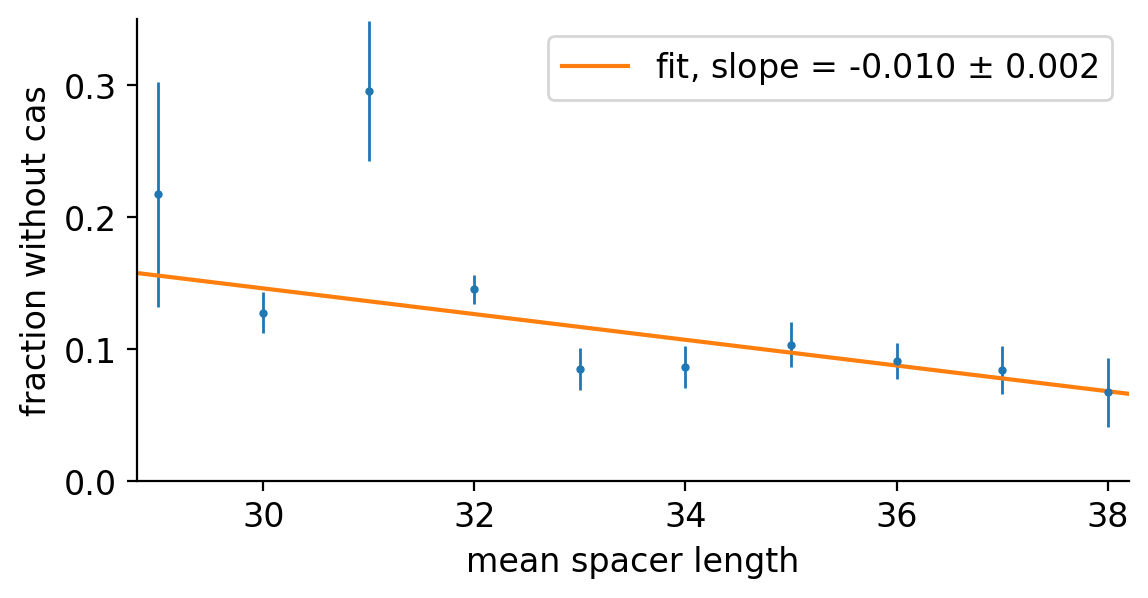

In [9]:
fig, ax = subplots(figsize=(6.4, 3), dpi=200)

errorbar((lmin:lmax)[lrange],P_nocas_l[lrange], linestyle="none",marker="o",markersize=2,
    yerr=std_P_nocas_l[lrange], elinewidth=1,capsize=0)

plot(lmin:lmax,m*(lmin:lmax) .+ c)

# hlines(P_nocas,27,41,color="grey")

fs = 12
xlabel("mean spacer length", fontsize=fs)
ylabel("fraction without cas", fontsize=fs)

xlim(28.8,38.2)
ylim(0,0.35)

xticks(30:2:38, fontsize=fs)
yticks(0:.1:.3, fontsize=fs)

legend(["fit, slope = -0.010 \$\\pm\$ $(round(dm,sigdigits=1))"], fontsize=fs)

ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)

# savefig("P_nocas.svg",format="svg")

In [10]:
m_0 = m

-0.0097381901332607

### permutation test
Note: The following code cell reuses the above variables.

In [11]:
# num = 10^6

# m_values = Float64[]

# @time for i in 1:num
#     mspacerlens_shuf = shuffle(mspacerlens_all1)
    
#     # get frequencies for each length
#     freqs_l_cc1  = get_freqs_l(mspacerlens_shuf[1:num_gbs_cc], lmin=lmin, lmax=lmax)
#     freqs_l_cnc1 = get_freqs_l(mspacerlens_shuf[num_gbs_cc+1:end], lmin=lmin, lmax=lmax)
    
#     p_l_cc1  = freqs_l_cc1 /num_gbs_cc
#     p_l_cnc1 = freqs_l_cnc1/num_gbs_cnc;
    
#     P_nocas_l = freqs_l_cnc1./(freqs_l_cc1 .+ freqs_l_cnc1)
    
#     var_l_cc1  = num_gbs_cc *p_l_cc1 .*(1 .- p_l_cc1 )
#     var_l_cnc1 = num_gbs_cnc*p_l_cnc1.*(1 .- p_l_cnc1)
    
#     r = freqs_l_cc1./freqs_l_cnc1
    
#     var_r = r.^2 .* (var_l_cc1./freqs_l_cc1.^2 .+ var_l_cnc1./freqs_l_cnc1.^2)
    
#     std_P_nocas_l = sqrt.(var_r)./(1 .+ r).^2;
    
#     m, c, dm, dc = linreg(x=(lmin:lmax)[lrange], y=P_nocas_l[lrange], dy=std_P_nocas_l[lrange])
    
#     push!(m_values,m)
# end

In [12]:
# count(x->x<m_0, m_values)/num